In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


دانلود دیتاست فقط برای بار اول

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import random
import torch
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#  Set Seed
SEED = 42
seed=42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU Available:", gpus[0])
else:
    print("⚠️ GPU not found. Running on CPU.")

IMG_SIZE = (224, 224)
input_shape = (*IMG_SIZE, 3)
NUM_CLASSES = 4
epochs = 40
batch_size = 32
learning_rate = 8e-4

train_dir = "/content/drive/MyDrive/HW2/Data/train"
val_dir = "/content/drive/MyDrive/HW2/Data/valid"
test_dir = "/content/drive/MyDrive/HW2/Data/test"

# --- Custom Augmentation with 20% probability
def custom_augment(img):
    if tf.random.uniform([]) < 0.2:
        img = tf.image.resize(img, [int(IMG_SIZE[0]*1.2), int(IMG_SIZE[1]*1.2)])
        img = tf.image.random_crop(img, size=[*IMG_SIZE, 3])
    if tf.random.uniform([]) < 0.2:
        img = tf.image.flip_left_right(img)
    if tf.random.uniform([]) < 0.2:
        img = tf.image.flip_up_down(img)
    if tf.random.uniform([]) < 0.2:
        img = tf.image.adjust_contrast(img, 2.0)
    return img

def preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = custom_augment(img)
    return img
def normalize(img):
    return tf.image.convert_image_dtype(img, tf.float32)  # Scales to [0, 1]


# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda img: preprocess_input(custom_augment(img))
)
val_test_datagen = ImageDataGenerator(preprocessing_function=lambda img: preprocess_input(img)
)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=batch_size,
    class_mode='categorical', shuffle=True
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# --- Class Weights
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# --- Transfer Learning Model
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
steps_per_epoch = train_generator.samples // batch_size

model = models.Model(inputs=base_model.input, outputs=output)
# --- Compile
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks
callbacks = [
    #EarlyStopping(patience=5, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,verbose=1)

]

# --- Train
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# --- Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



✅ GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 434s 21s/step - accuracy: 0.3846 - loss: 1.6591 - val_accuracy: 0.5000 - val_loss: 0.9139 - learning_rate: 8.0000e-04
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.5933 - loss: 0.9076 - val_accuracy: 0.6806 - val_loss: 0.7561 - learning_rate: 8.0000e-04
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 476ms/step - accuracy: 0.7230 - loss: 0.6799 - val_accuracy: 0.7222 - val_loss: 0.7364 - learning_rate: 8.0000e-04
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - accuracy: 0.7511 - loss: 0.5763 - val_accuracy: 0.6667 - val_loss: 0.7686 - learning_rate: 8.0000e-04
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - accuracy: 0.7760 - loss: 0.5538 - val_accuracy: 0.7361 - val_loss: 0.6232 - learning_rate: 8.0000e-04
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 427ms/step - accuracy: 0.8250 - loss: 0.4530 - val_accuracy: 0.7778 - val_loss: 0.6573 - learning_rate: 8.0000e-04
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - accuracy

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 639ms/step
Classification Report:

                         precision    recall  f1-score   support

         adenocarcinoma       0.79      0.75      0.77       120
   large.cell.carcinoma       0.78      0.75      0.76        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.71      0.78      0.74        90

               accuracy                           0.80       315
              macro avg       0.82      0.81      0.82       315
           weighted avg       0.80      0.80      0.80       315

Confusion Matrix:



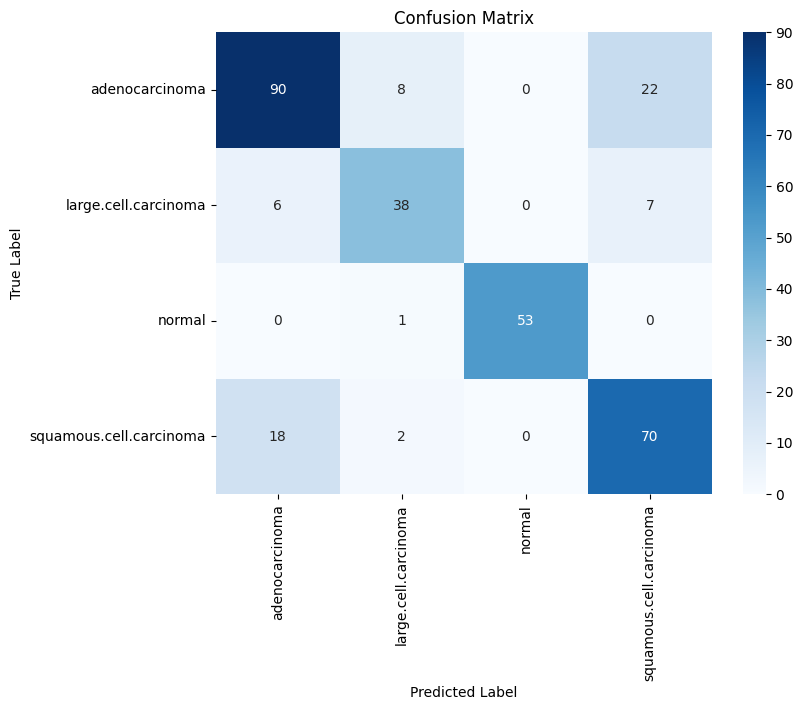

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- ماتریس سردرگمی
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n")
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Set Seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU Available:", gpus[0])
else:
    print("⚠️ GPU not found. Running on CPU.")


IMG_SIZE = (224, 224)
input_shape = (*IMG_SIZE, 3)
NUM_CLASSES = 4
epochs = 35
batch_size = 32
learning_rate = 0.0004

train_dir = "/content/drive/MyDrive/HW2/Data/train"
val_dir = "/content/drive/MyDrive/HW2/Data/valid"
test_dir = "/content/drive/MyDrive/HW2/Data/test"

# --- Custom Augmentation with 20% probability
def custom_augment(img):

    if tf.random.uniform([]) < 0.2:
        img = tf.image.resize(img, [int(IMG_SIZE[0]*1.2), int(IMG_SIZE[1]*1.2)])
        img = tf.image.random_crop(img, size=[*IMG_SIZE, 3])
    if tf.random.uniform([]) < 0.2:
        img = tf.image.flip_left_right(img)
    if tf.random.uniform([]) < 0.2:
        img = tf.image.flip_up_down(img)
    if tf.random.uniform([]) < 0.2:
        img = tf.image.adjust_contrast(img, 2.0)
    return img

def preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = custom_augment(img)
    return img
def normalize(img):
    return tf.image.convert_image_dtype(img, tf.float32)  # Scales to [0, 1]
# --- ImageDataGenerators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess
)
val_datagen = ImageDataGenerator(preprocessing_function=normalize)
test_datagen = ImageDataGenerator(preprocessing_function=normalize)

# --- Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# --- Class Weights
y_train = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: w for i, w in enumerate(class_weights_array)}
from tensorflow.keras.initializers import HeNormal

initializer = HeNormal()




# Model definition
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(4, activation='softmax'),
])

# Optimizer with weight decay
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=1e-5)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Callbacks
callbacks = [
    #EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Train
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



✅ GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 810ms/step - accuracy: 0.2989 - loss: 1.3755 - val_accuracy: 0.1806 - val_loss: 2.3330 - learning_rate: 4.0000e-04
Epoch 2/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 634ms/step - accuracy: 0.4219 - loss: 1.1675 - val_accuracy: 0.1806 - val_loss: 1.9494 - learning_rate: 4.0000e-04
Epoch 3/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - accuracy: 0.4531 - loss: 1.0917 - val_accuracy: 0.1944 - val_loss: 1.5309 - learning_rate: 4.0000e-04
Epoch 4/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 690ms/step - accuracy: 0.5102 - loss: 1.0749 - val_accuracy: 0.2222 - val_loss: 1.3670 - learning_rate: 4.0000e-04
Epoch 5/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 618ms/step - accuracy: 0.5453 - loss: 1.0072 - val_accuracy: 0.2500 - val_loss: 1.2834 - learning_rate: 4.0000e-04
Epoch 6/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 563ms/step - accuracy: 0.5097 - loss: 1.0449 - val_accuracy: 0.3056 - val_loss: 1.2564 - learning_rate: 4.0000e-04
Epoch 7/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 493ms/step - acc

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step
Classification Report:

                         precision    recall  f1-score   support

         adenocarcinoma       0.43      0.07      0.13       120
   large.cell.carcinoma       0.22      0.80      0.34        51
                 normal       1.00      1.00      1.00        54
squamous.cell.carcinoma       0.71      0.40      0.51        90

               accuracy                           0.44       315
              macro avg       0.59      0.57      0.49       315
           weighted avg       0.57      0.44      0.42       315



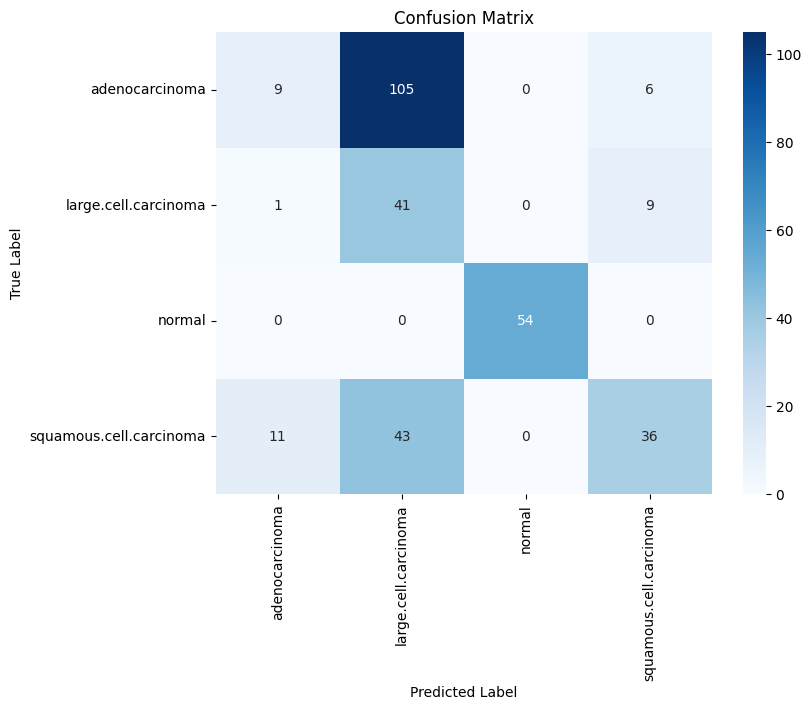

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)


y_true = test_generator.classes  # چون shuffle=False، ترتیب حفظ شده


class_names = list(test_generator.class_indices.keys())


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)



plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

